# Random Forest

In this code the idea is to train a Random Forest to be able to predict the fire at the day t + 1. The main objective of this model is to evaluate if our 3 addictional predictors (Distance, Wind Propagation, Wind Direction) can bring added value to the prediction.

Because at the end the goal is mostly to evaluate the predictors, we selected a subsample of 2000 events for the train set and 1000 for the test set, which correspond to ca. 8 million pixels and 4 million pixels respectively. This choice is to save time due to the computational burden (which is still a lot), while mainting quite a lot of entries.

In [ ]:
import os
import pickle
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Set the random seed for reproducibility
torch.manual_seed(42)

# Total samples to select
total_samples = 3000
train_samples = 2000
test_samples = 1000

# Paths to your data files
data_folder = os.path.join('..', '..', 'Data', 'feature_engineered')
file_path1 = os.path.join(data_folder, 'X_fe.pkl')
file_path2 = os.path.join(data_folder, 'y_fe.pkl')

# Load the data
with open(file_path1, 'rb') as f:
    X_total = pickle.load(f)
with open(file_path2, 'rb') as f:
    y_total = pickle.load(f)

# Generate random indices for selection
indices = torch.randperm(len(X_total))[:total_samples]

# Split indices into training and testing
train_indices = indices[:train_samples]
test_indices = indices[train_samples:train_samples + test_samples]

# Select the samples for training and testing
X_fe_train = X_total[train_indices]
y_fe_train = y_total[train_indices]
X_fe_test = X_total[test_indices]
y_fe_test = y_total[test_indices]

# Saving the training data
train_X_path = os.path.join(data_folder, 'X_fe_train.pkl')
train_y_path = os.path.join(data_folder, 'y_fe_train.pkl')
with open(train_X_path, 'wb') as f:
    pickle.dump(X_fe_train, f)
with open(train_y_path, 'wb') as f:
    pickle.dump(y_fe_train, f)

# Saving the testing data
test_X_path = os.path.join(data_folder, 'X_fe_test.pkl')
test_y_path = os.path.join(data_folder, 'y_fe_test.pkl')
with open(test_X_path, 'wb') as f:
    pickle.dump(X_fe_test, f)
with open(test_y_path, 'wb') as f:
    pickle.dump(y_fe_test, f)

print("Training and testing samples stored.")
print("Shape of X_fe_train:", X_fe_train.shape)
print("Shape of y_fe_train:", y_fe_train.shape)
print("Shape of X_fe_test:", X_fe_test.shape)
print("Shape of y_fe_test:", y_fe_test.shape)


In this second chunk we iterate trhrough the train sets (X and y) and we join them into a dataframe to be able to work with them and training a random forest. In this model we treat the entries pixelwise

In [3]:
pixel_data_list = []

# Iterate over the samples of X_fe_train and y_fe_train
for sample_idx in range(X_fe_train.shape[0]):
    # Retrieve the feature tensor for the current sample
    features_tensor = X_fe_train[sample_idx]
    
    # Retrieve the target tensor (y) for the current sample
    target_tensor = y_fe_train[sample_idx]
    
    # For each pixel in the feature tensor
    for row in range(features_tensor.shape[0]):
        for col in range(features_tensor.shape[1]):
            # Create a dictionary to represent the current pixel
            pixel_data = {}
            # Add the feature values as columns in the DataFrame
            for feature_idx in range(features_tensor.shape[2]):
                # Assign the current attribute's value to the pixel
                pixel_data[f'feature_{feature_idx+1}'] = features_tensor[row, col, feature_idx].item()
            
            # Add the pixel's target attribute from the y tensor to the dictionary
            pixel_data['target'] = target_tensor[row, col].item()
            
            # Append the dictionary to our list of pixel data
            pixel_data_list.append(pixel_data)

# Create a DataFrame using the list of pixel data
pixel_df = pd.DataFrame(pixel_data_list)

# Optionally print the shape or head of the DataFrame to check
print(pixel_df.shape)
print(pixel_df.head())


(8192000, 16)
   feature_1   feature_2  feature_3   feature_4   feature_5  feature_6  \
0       17.0  129.941940   2.038104  280.487183  297.019867   0.005786   
1       17.0  128.303619   2.032815  280.436432  297.027832   0.005780   
2       19.0  126.687485   2.026618  280.386139  297.035767   0.005774   
3       19.0  125.100204   2.019579  280.336823  297.043671   0.005769   
4       18.0  123.548439   2.011763  280.289032  297.051514   0.005763   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0        0.0  -3.911050     2710.0    0.013650   58.152332         0.0   
1        0.0  -3.968453     4229.0    0.198864   58.035343         0.0   
2        0.0  -4.011178     2936.0    0.198864   57.921967         0.0   
3        0.0  -4.041745     2936.0    0.198864   57.812614         0.0   
4        0.0  -4.067156     3585.0    3.577682   57.707703         0.0   

   feature_13  feature_14  feature_15  target  
0   40.199501         0.0         0.0     0.0  


The further datapreprocessing is to assign the correct name to the features, which is indispensable to try different configuration and have in mind what kind of information each variable represents

In [4]:
new_column_names = {
    'feature_1': 'Elevation',
    'feature_3': 'Wind_speed',
    'feature_4': 'Min_temp',
    'feature_5': 'Max_temp',
    'feature_6': 'Humidity',
    'feature_7': 'Precipitation',
    'feature_8': 'Drought',
    'feature_9': 'Vegetation',
    'feature_10': 'Population_density',
    'feature_11': 'Energy_release',
    'feature_12': 'Mask',
    'feature_13': 'Distance',
    'feature_14': 'Wind_Propagation',
    'feature_15': 'Wind_trajectory'
}

pixel_df.drop(columns=['feature_2'], inplace=True)

pixel_df.rename(columns=new_column_names, inplace=True)


In this part we first eliminate the entries of the fire mask at day t which as value of -1.0. This represents pixel for wich the cloud cover introduces uncertainty on the measurment of the variables via remote sensing. We belive these pixels could  to bias in our results. Then because the random forest need. We tried different configuration, and augmenting the number of pixels with no fire led to a better precision but a worse recall. We tried to identify a good configuration by evaluating the F1 score. This led to a ratio of 1:20 of fire:non-fire.

In [9]:
# Remove rows where 'Mask' or 'target' values are -1.000000
rows_to_drop = pixel_df[(pixel_df['Mask'] == -1.000000) | (pixel_df['target'] == -1.000)].index
pixel_df.drop(rows_to_drop, inplace=True)

# Set a random seed for reproducibility
np.random.seed(42)

# Round the number of rows with 'target' equal to 1 to the nearest integer
num_target_1 = int(pixel_df['target'].sum())

# Randomly select rows where 'target' has a value of 0
# so that the total number of rows with 'target' equal to 0 is equal to the number of rows with 'target' equal to 1
rows_target_0 = pixel_df[pixel_df['target'] == 0].index
rows_to_keep_target_0 = np.random.choice(rows_target_0, size=num_target_1*20, replace=False)

# Create a new balanced DataFrame using the selected rows
balanced_df = pixel_df.loc[pixel_df['target'] == 1].copy()
balanced_df = pd.concat([balanced_df, pixel_df.loc[rows_to_keep_target_0]])

balanced_df


,Elevation,Wind_speed,Min_temp,Max_temp,Humidity,Precipitation,Drought,Vegetation,Population_density,Energy_release,Mask,Distance,Wind_Propagation,Wind_trajectory,target
171,25.0,1.480936,280.038361,297.215057,0.005682,0.000000,-2.579317,4533.0,15.112425,59.165180,0.0,2.828427,0.0,0.682421,1.0
172,25.0,1.478768,280.086426,297.212616,0.005682,0.000000,-2.607681,4533.0,18.809578,59.384743,0.0,3.605551,0.0,0.734017,1.0
231,25.0,1.492248,279.875580,297.238068,0.005677,0.000000,-2.512801,6034.0,1.781425,58.481659,0.0,1.414214,0.0,0.190179,1.0
232,25.0,1.487910,279.917725,297.235229,0.005677,0.000000,-2.543429,7152.0,31.809210,58.692970,0.0,1.000000,0.0,0.246162,1.0
233,25.0,1.484172,279.961945,297.232391,0.005677,0.000000,-2.583336,7152.0,12.194407,58.909325,0.0,1.000000,0.0,0.470059,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5556826,1248.0,1.595683,279.274811,292.631989,0.003968,0.000000,-1.035736,2694.0,0.115359,44.555119,0.0,5.000000,0.0,0.958098,0.0
1366067,2054.0,2.694889,285.571838,301.987213,0.006001,0.000000,0.976659,6068.0,0.000000,80.533661,0.0,10.440307,0.0,0.000000,0.0
2488256,5.0,2.215159,285.878754,299.545258,0.010306,0.447216,-1.451233,6178.0,0.000000,21.355818,0.0,16.552946,0.0,0.999860,0.0
2941089,1533.0,4.187360,283.912537,303.558411,0.004720,0.000045,-2.272292,2077.0,0.000000,83.826225,0.0,17.464249,0.0,0.761425,0.0


In this chunk we tried to find the better configuration of some hyperparameters with only using the 2000 samples and splitting them 80/20. The best model was saved and then the best hyperparameters were used to try different configurations of the different variables. The best hyperparameters were selected according to a 10 fold cross validation evaluating the best accuracy on the train set. We couldn't try a lot of parameters because it was very computational intensive, but at least we tried 256 different configurations (4x4 hyperparameters).

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Split the dataset into training and testing sets
X = balanced_df.drop(columns=['target'])
y = balanced_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [2, 4, 8, 10],
}

# Perform the search for the best hyperparameters using cross-validation
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Train the best model on the training set
best_rf = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Matrice di confusione:
[[7448   45]
 [  91  458]]
Accuracy sul set di test: 0.9830887838846059


Here we saved our best model

In [ ]:
import os
import joblib

data_folder = os.path.join('..', '..', 'Data', 'rf_models')
file_path = os.path.join(data_folder, 'rf_complete.pkl')

joblib.dump(best_rf, file_path)


Here we trained the random forest with the best hyperparameter on the balanced dataset with all the 3 new features.

In [ ]:
import os
import joblib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier


# Split features and targets
X = balanced_df.drop(columns=['target'])
y = balanced_df['target']

# Load the best model's hyperparameters
data_folder = os.path.join('..', '..', 'Data', 'rf_models')
model_path = os.path.join(data_folder, 'rf_complete.pkl')
best_rf = joblib.load(model_path)

# Create a new RandomForest model using the best model's parameters
rf_final = RandomForestClassifier(
    n_estimators=best_rf.n_estimators,
    max_depth=best_rf.max_depth,
    min_samples_split=best_rf.min_samples_split,
    min_samples_leaf=best_rf.min_samples_leaf,
    random_state=42
)

# Train the model with the entire balanced dataset
rf_final.fit(X, y)

# Save the fully trained model
final_model_path = os.path.join(data_folder, 'rf_final.pkl')
joblib.dump(rf_final, final_model_path)


As we did for the test set we also converted the matrices into pixels for the test set in the same way we did before to execute the evaluation of the models on it.

In [10]:
pixel_data_list_test = []

# Iterate over the samples of X_fe_test and y_fe_test
for sample_idx in range(X_fe_test.shape[0]):
    # Retrieve the feature tensor for the current sample
    features_tensor = X_fe_test[sample_idx]
    
    # Retrieve the target tensor (y) for the current sample
    target_tensor = y_fe_test[sample_idx]
    
    # For each pixel in the feature tensor
    for row in range(features_tensor.shape[0]):
        for col in range(features_tensor.shape[1]):
            # Create a dictionary to represent the current pixel
            pixel_data_test = {}
            
            # Add the feature values as columns in the DataFrame
            for feature_idx in range(features_tensor.shape[2]):
                # Assign the current attribute's value to the pixel
                pixel_data_test[f'feature_{feature_idx+1}'] = features_tensor[row, col, feature_idx].item()
            
            # Add the pixel's target attribute from the y tensor to the dictionary
            pixel_data_test['target'] = target_tensor[row, col].item()
            
            # Append the dictionary to our list of pixel data
            pixel_data_list_test.append(pixel_data_test)

# Create a DataFrame using the list of pixel data
pixel_df_test = pd.DataFrame(pixel_data_list_test)

# Optionally print the shape or head of the DataFrame to check
print(pixel_df_test.shape)
print(pixel_df_test.head())


(4096000, 16)
   feature_1  feature_2  feature_3   feature_4   feature_5  feature_6  \
0      464.0  64.707497   3.021777  279.242523  294.727509   0.005980   
1      462.0  64.624336   3.023418  279.241394  294.738037   0.005987   
2      460.0  64.496925   3.025670  279.239563  294.748505   0.005995   
3      460.0  64.330299   3.028472  279.237122  294.758942   0.006003   
4      457.0  64.129494   3.031759  279.234161  294.769379   0.006010   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0        0.0  -2.577915     3231.0    0.701497   27.608435         0.0   
1        0.0  -2.571581     3830.0    2.079772   27.567842         0.0   
2        0.0  -2.562931     4416.0    0.348947   27.530993         0.0   
3        0.0  -2.550874     4043.0    0.348947   27.497467         0.0   
4        0.0  -2.533433     4043.0    0.981675   27.466850         0.0   

   feature_13  feature_14  feature_15  target  
0   41.773197         0.0         0.0    -1.0  
1   40

To maintain consistency we also did the same preprocessing for the test set.

In [14]:
# Remove the 'feature_2' column from the test dataset
pixel_df_test.drop(columns=['feature_2'], inplace=True)


# Rename the columns using the new column names in the test dataset
pixel_df_test.rename(columns=new_column_names, inplace=True)

# Optionally print the shape or head of the DataFrame to check
print(pixel_df_test.shape)
print(pixel_df_test.head())

rows_to_drop_test = pixel_df_test[(pixel_df_test['Mask'] == -1.000000) | (pixel_df_test['target'] == -1.000)].index
pixel_df_test.drop(rows_to_drop_test, inplace=True)

(4096000, 15)
   Elevation  Wind_speed    Min_temp    Max_temp  Humidity  Precipitation  \
0      464.0    3.021777  279.242523  294.727509  0.005980            0.0   
1      462.0    3.023418  279.241394  294.738037  0.005987            0.0   
2      460.0    3.025670  279.239563  294.748505  0.005995            0.0   
3      460.0    3.028472  279.237122  294.758942  0.006003            0.0   
4      457.0    3.031759  279.234161  294.769379  0.006010            0.0   

    Drought  Vegetation  Population_density  Energy_release  Mask   Distance  \
0 -2.577915      3231.0            0.701497       27.608435   0.0  41.773197   
1 -2.571581      3830.0            2.079772       27.567842   0.0  40.792156   
2 -2.562931      4416.0            0.348947       27.530993   0.0  39.812057   
3 -2.550874      4043.0            0.348947       27.497467   0.0  38.832977   
4 -2.533433      4043.0            0.981675       27.466850   0.0  37.854988   

   Wind_Propagation  Wind_trajectory  targ

Here the evaluation of the performance of the Random Forest with all the predictors

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#pixel_df_test.drop(columns=['predicted'], inplace=True)

model_path = os.path.join('..', '..', 'Data', 'rf_models', 'rf_final.pkl')

rf_final = joblib.load(model_path)

# Assuming pixel_df_test is already preprocessed and ready for prediction
X_test = pixel_df_test.drop(columns=['target'])  # Extract features for prediction
y_test = pixel_df_test['target']  # Actual labels

# Make predictions
predicted = rf_final.predict(X_test)

# Add predictions to pixel_df_test
pixel_df_test['predicted'] = predicted

# Calculate metrics
conf_matrix = confusion_matrix(y_test, predicted)
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)
f1 = f1_score(y_test, predicted)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[3899907   25191]
 [  21326   25536]]
Accuracy: 0.9882886534607599
Precision: 0.5034005559169673
Recall: 0.5449191242371217
F1 Score: 0.5233376712539323


Here we try the same model Random Forest on the same training set with the same hyperparameters without the addictional variables.

In [ ]:
# Assume balanced_df is already loaded and ready
balanced_df_base = balanced_df.drop(columns=['Distance', 'Wind_Propagation', 'Wind_trajectory'])

X_base = balanced_df_base.drop(columns=['target'])
y_base = balanced_df_base['target']

data_folder = os.path.join('..', '..', 'Data', 'rf_models')
model_path = os.path.join(data_folder, 'rf_complete.pkl')
best_rf = joblib.load(model_path)

# Create a new RandomForest model using the loaded parameters
rf_final_base = RandomForestClassifier(
    n_estimators=best_rf.n_estimators,
    max_depth=best_rf.max_depth,
    min_samples_split=best_rf.min_samples_split,
    min_samples_leaf=best_rf.min_samples_leaf,
    random_state=42
)

# Train the new model with the modified dataset
rf_final_base.fit(X_base, y_base)

final_model_path_base = os.path.join(data_folder, 'rf_final_base.pkl')
joblib.dump(rf_final_base, final_model_path_base)


Here we evaluated the performance of the model without the addictional predictors and realized that we obtained similar result. What we found out is that with all the predictors the model doesen't change and become even a litell bit worse.

In [14]:
# Assuming you already have X_test and y_test prepared from your earlier processing steps

# Drop the specified columns from X_test to create X_test_base
# (List columns to drop - the same ones you initially removed to train rf_final_base)
columns_to_drop = ['Distance', 'Wind_Propagation', 'Wind_trajectory']
X_test_base = X_test.drop(columns=columns_to_drop)

# Load the rf_final_base model
model_path_base = os.path.join('..', '..', 'Data', 'rf_models', 'rf_final_base.pkl')
rf_final_base = joblib.load(model_path_base)

# Make predictions using rf_final_base on X_test_base
predicted_base = rf_final_base.predict(X_test_base)

# The target labels remain the same so y_test_base is simply y_test
y_test_base = y_test

# Calculate metrics using predictions
conf_matrix_base = confusion_matrix(y_test_base, predicted_base)
accuracy_base = accuracy_score(y_test_base, predicted_base)
precision_base = precision_score(y_test_base, predicted_base, average='binary')  # adjust average method if not binary
recall_base = recall_score(y_test_base, predicted_base, average='binary')
f1_base = f1_score(y_test_base, predicted_base, average='binary')

# Print the results
print("Confusion Matrix for the base model:")
print(conf_matrix_base)
print("Accuracy for the base model:", accuracy_base)
print("Precision for the base model:", precision_base)
print("Recall for the base model:", recall_base)
print("F1 Score for the base model:", f1_base)


Confusion Matrix for the base model:
[[3910109   14989]
 [  23645   23217]]
Accuracy for the base model: 0.9902733159447729
Precision for the base model: 0.6076794220803016
Recall for the base model: 0.4954334001963211
F1 Score for the base model: 0.5458456764000564


Since we did not obtain the desired results, we tried to see if different configurations of variables would lead to better results. We did this with simpler model hyperparameters (like maximum depth minor) but just to get an idea, here we found that the best configuration is with just wind_trajectory and wind_speed (based on F1 Score)

In [19]:
import itertools
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Variables and combinations
variables = ['Distance', 'Wind_Propagation', 'Wind_trajectory']
combinations = list(itertools.combinations(variables, r) for r in range(1, len(variables) + 1))
combinations = [item for sublist in combinations for item in sublist]  # Flatten the list

# Assume balanced_df is already loaded and ready
X = balanced_df.drop(columns=['target'])
y = balanced_df['target']

# Assume pixel_df_test is already prepared and ready for use
X_test_full = pixel_df_test.drop(columns=['target'])
y_test = pixel_df_test['target']

# Model parameters (assuming they have been defined or loaded)
n_estimators = 100  # Example, define according to your data
max_depth = 10
min_samples_split = 2
min_samples_leaf = 1

for combo in combinations:
    model_name = 'rf_' + '_'.join(combo).lower()
    columns_to_drop = list(combo)
    X_train = X.drop(columns=columns_to_drop)
    X_test = X_test_full.drop(columns=columns_to_drop)
    
    # Train the model
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf_model.fit(X_train, y)

    # Evaluate the model
    predictions = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='binary')
    recall = recall_score(y_test, predictions, average='binary')
    f1 = f1_score(y_test, predictions, average='binary')

    # Print the results
    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("----------\n")


Modello: rf_distance
Confusion Matrix:
[[3904031   21067]
 [  34064   12798]]
Accuracy: 0.9861199508554971
Precision: 0.377912298833604
Recall: 0.2730997396611327
F1 Score: 0.31706863874540114
----------

Modello: rf_wind_propagation
Confusion Matrix:
[[3894924   30174]
 [  30718   16144]]
Accuracy: 0.9846695334293397
Precision: 0.34854700116585347
Recall: 0.3445008749093082
F1 Score: 0.34651212706589396
----------

Modello: rf_wind_trajectory
Confusion Matrix:
[[3894078   31020]
 [  30406   16456]]
Accuracy: 0.9845350909878247
Precision: 0.34661723818350326
Recall: 0.35115872135205495
F1 Score: 0.34887320061905064
----------

Modello: rf_distance_wind_propagation
Confusion Matrix:
[[3906505   18593]
 [  35115   11747]]
Accuracy: 0.9864782122679987
Precision: 0.38717864205669084
Recall: 0.2506721864197004
F1 Score: 0.3043185409704412
----------

Modello: rf_distance_wind_trajectory
Confusion Matrix:
[[3903089   22009]
 [  33709   13153]]
Accuracy: 0.9859721648757792
Precision: 0.374068

Because of what we found out before we tried a model with the same hyperparameters only without the variable Distance,

In [ ]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the model's base parameters
data_folder = os.path.join('..', '..', 'Data', 'rf_models')
model_path = os.path.join(data_folder, 'rf_complete.pkl')
best_rf = joblib.load(model_path)

# Prepare the training dataset
X_train_best = balanced_df.drop(columns=['target', 'Distance'])
y_train_best = balanced_df['target']

# Display loaded hyperparameters
print("Loaded model hyperparameters:")
print("Number of estimators:", best_rf.n_estimators)
print("Maximum depth:", best_rf.max_depth)
print("Minimum samples split:", best_rf.min_samples_split)
print("Minimum samples leaf:", best_rf.min_samples_leaf)

# Train the RandomForest model with the loaded parameters
rf_best = RandomForestClassifier(
    n_estimators=best_rf.n_estimators,
    max_depth=best_rf.max_depth,
    min_samples_split=best_rf.min_samples_split,
    min_samples_leaf=best_rf.min_samples_leaf,
    random_state=42
)
rf_best.fit(X_train_best, y_train_best)

# Path to save the trained model
final_model_path = os.path.join(data_folder, 'rf_best.pkl')

# Save the trained model
joblib.dump(rf_best, final_model_path)
print("The model was successfully saved to:", final_model_path)


In [15]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the already trained model
data_folder = os.path.join('..', '..', 'Data', 'rf_models')
final_model_path = os.path.join(data_folder, 'rf_best.pkl')
rf_best = joblib.load(final_model_path)

# Assume that pixel_df_test is already defined and prepared as above
# Check if 'Distance' is one of the columns and remove it if present
if 'Distance' in pixel_df_test.columns:
    X_test_best = pixel_df_test.drop(columns=['Distance'])
else:
    X_test_best = pixel_df_test.copy()

# Separate the targets
y_test_best = X_test_best.pop('target')

# Evaluate the model on the test set
predicted_best = rf_best.predict(X_test_best)
conf_matrix_best = confusion_matrix(y_test_best, predicted_best)
accuracy_best = accuracy_score(y_test_best, predicted_best)
precision_best = precision_score(y_test_best, predicted_best, average='binary')
recall_best = recall_score(y_test_best, predicted_best, average='binary')
f1_best = f1_score(y_test_best, predicted_best, average='binary')

# Print the results
print("Confusion Matrix for the best model:")
print(conf_matrix_best)
print("Accuracy for the best model:", accuracy_best)
print("Precision for the best model:", precision_best)
print("Recall for the best model:", recall_best)
print("F1 Score for the best model:", f1_best)

Confusion Matrix for the best model:
[[3906530   18568]
 [  23550   23312]]
Accuracy for the best model: 0.9893961671315925
Precision for the best model: 0.5566380133715377
Recall for the best model: 0.4974606290811318
F1 Score for the best model: 0.5253882040071217


Here we try to visualize our results through 6 samples which are neither in the train nor in the test set. We selected some good, some bad, some with cloud a little bit to have an overview.

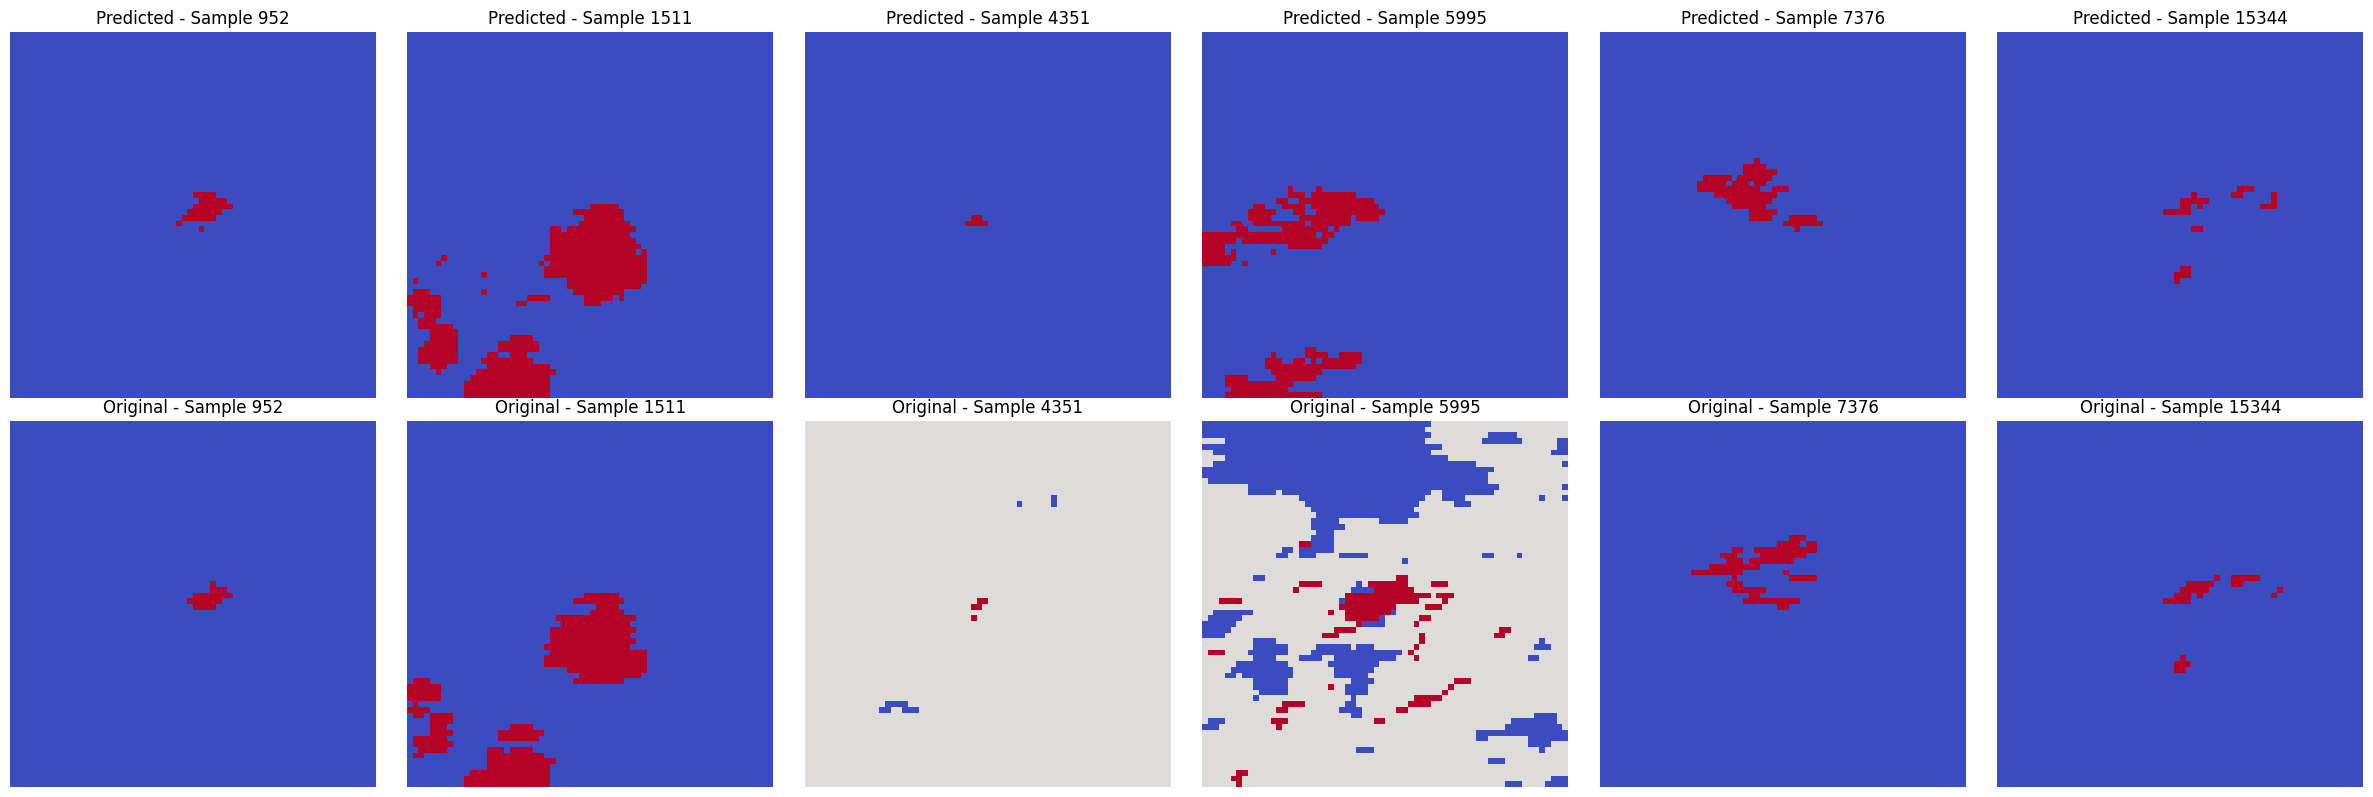

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Specific indices of samples to select
specific_indices = [952, 1511, 4351, 5995, 7376, 15344]

# Extract specific samples
X_random = X_total[specific_indices]
y_random = y_total[specific_indices]


# Prepare data for the DataFrame
pixel_data_list_random = []
for sample_idx in range(X_random.shape[0]):
    features_tensor = X_random[sample_idx]
    target_tensor = y_random[sample_idx]
    for row in range(features_tensor.shape[0]):
        for col in range(features_tensor.shape[1]):
            pixel_data = {}
            for feature_idx in range(features_tensor.shape[2]):
                pixel_data[f'feature_{feature_idx+1}'] = features_tensor[row, col, feature_idx].item()
            pixel_data['target'] = target_tensor[row, col].item()
            pixel_data_list_random.append(pixel_data)

# Convert to DataFrame and prepare for prediction
pixel_df_random = pd.DataFrame(pixel_data_list_random)
if 'feature_2' in pixel_df_random.columns:  # Assuming 'feature_2' is 'Distance'
    pixel_df_random.drop(columns=['feature_2'], inplace=True)
pixel_df_random.rename(columns=new_column_names, inplace=True)

# Remove the target column for prediction
X_random_prepared = pixel_df_random.drop(columns=['target'])
y_random_actual = pixel_df_random['target']

# Load the trained model
rf_best = joblib.load(final_model_path)

# Ensure the dataset for predictions does not contain the 'Distance' column
if 'Distance' in X_random_prepared.columns:
    X_random_prepared = X_random_prepared.drop(columns=['Distance'])

# Make predictions on specific samples
predicted_random = rf_best.predict(X_random_prepared)

# Organize predictions into matrices for visualization
predicted_matrices = []
original_matrices = []
for i in range(6):  # Now for 6 samples
    start_idx = i * 64 * 64
    end_idx = start_idx + 64 * 64
    predicted_matrix = predicted_random[start_idx:end_idx].reshape(64, 64)
    original_matrix = y_random[i].reshape(64, 64)
    predicted_matrices.append(predicted_matrix)
    original_matrices.append(original_matrix)

# Plotting without legends
fig, axes = plt.subplots(2, 6, figsize=(24, 8), gridspec_kw={'height_ratios': [1, 1]})  # Adjusted for 6 samples
for i, ax in enumerate(axes.flatten()):
    cmap = plt.cm.coolwarm
    if i < 6:  # Predicted matrices
        ax.imshow(predicted_matrices[i], cmap=cmap)
        ax.set_title(f'Predicted - Sample {specific_indices[i]}')
    else:  # Original matrices
        ax.imshow(original_matrices[i-6], cmap=cmap)
        ax.set_title(f'Original - Sample {specific_indices[i-6]}')
    ax.axis('off')

plt.tight_layout()
plt.show()
